In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, precision_score,\
    classification_report, auc, roc_auc_score
import matplotlib.pyplot as plt
from keras import layers
from keras.optimizers import SGD
from keras.layers import Flatten, Conv1D, MaxPooling1D
from imblearn.metrics import geometric_mean_score
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.utils import class_weight
import os
from sklearn.metrics import precision_recall_curve
from numpy import argmax
import winsound
import data_cleaning as dc
import importlib

In [234]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [235]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [236]:
importlib.reload(dc)
split_size = 0.2
balanced = True
show_number_of_data=True
X_train, X_test, y_train, y_test = dc.choose_data(balanced, split_size,show_number_of_data)

Train data: 81628
Test data: 16800


In [237]:
def build_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(32, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(Dense(8, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.85),
                   metrics='accuracy')
    return model

In [238]:
epochs=150
batch_size=128

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10 if epochs>100 else epochs/10,
    mode='auto',
    min_delta=0.0005,
    restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

model=build_model()

history=model.fit(X_train, y_train,shuffle=True, epochs=epochs, batch_size=batch_size,
                  callbacks=[early_stopping], validation_data=(X_val, y_val), verbose=True)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 13, 32)            128       
                                                                 
 dropout_56 (Dropout)        (None, 13, 32)            0         
                                                                 
 flatten_14 (Flatten)        (None, 416)               0         
                                                                 
 dense_63 (Dense)            (None, 32)                13344     
                                                                 
 dropout_57 (Dropout)        (None, 32)                0         
                                                                 
 dense_64 (Dense)            (None, 8)                 264       
                                                                 
 dropout_58 (Dropout)        (None, 8)               

In [239]:
duration = 500
freq = 300
winsound.Beep(freq, duration)

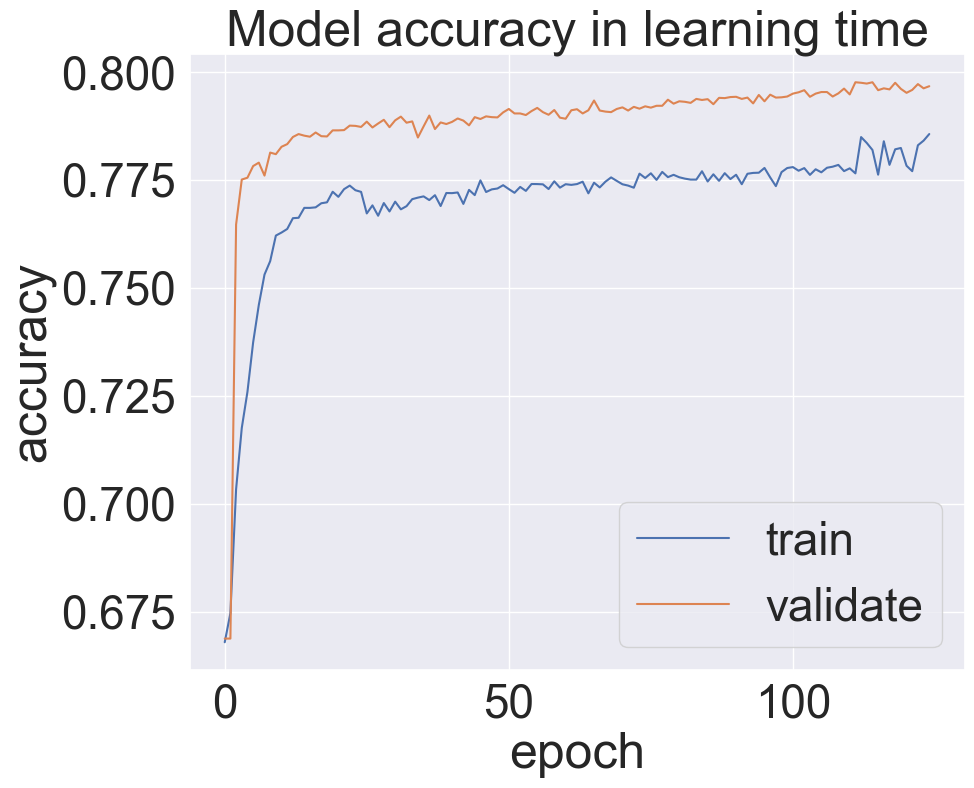

In [240]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy in learning time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')
plt.show()

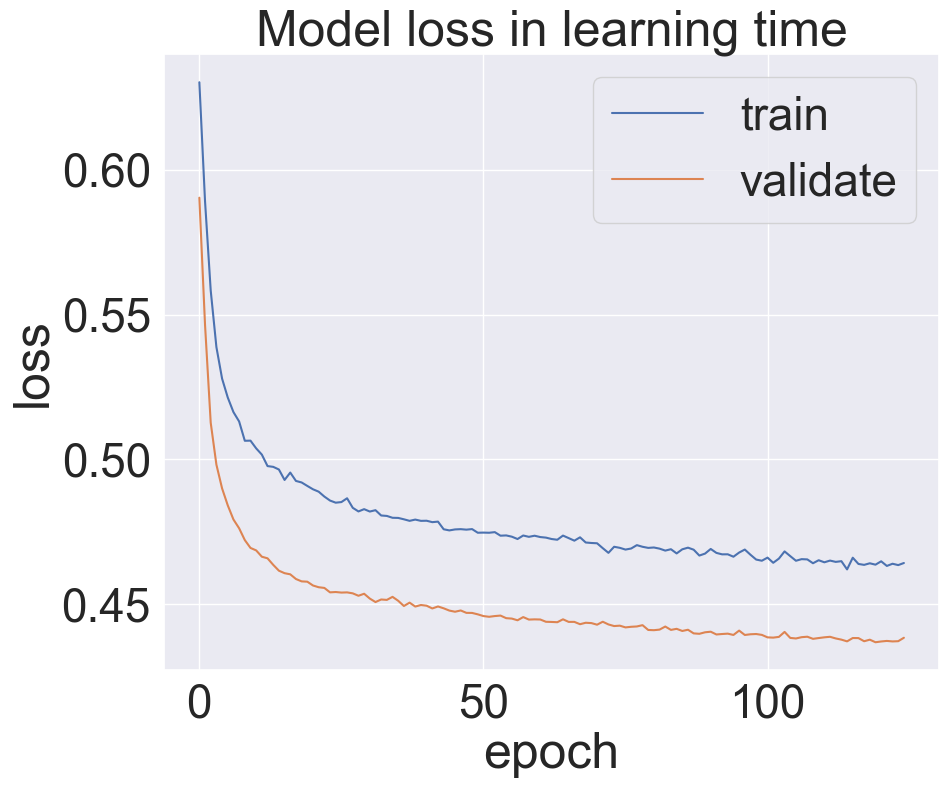

In [241]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss in learning time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [242]:
y_pred = model.predict(X_test, verbose=False)
fpr_org, tpr_org, _ = roc_curve(y_test, y_pred)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
best_score = ((2 * precision * recall) / (precision + recall))
best_score = best_score[~np.isnan(best_score)]
best_thresholds_org = round(thresholds[argmax(best_score)],2)
print("Best threshold :", best_thresholds_org)

y_pred = y_pred > 0.5

cm=confusion_matrix(y_test, y_pred)
print('\nACC-org :', round(accuracy_score(y_test, y_pred), 3))
print('AUC-org :', round(auc(fpr_org, tpr_org), 3))
print('G-mean-org :', round(geometric_mean_score(y_test, y_pred.ravel()), 3))
print('F1-org :', round(f1_score(y_test, y_pred), 3))
print('Sens-org :', round(cm[1,1]/(cm[1,0]+cm[1,1]), 3))
print('Spec-org :', round(cm[0,0]/(cm[0,0]+cm[0,1]), 3))
print('Prec-org :', round(precision_score(y_test, y_pred), 3))
print('\nConfusion matrix\n', confusion_matrix(y_test, y_pred))

Best threshold : 0.47

ACC-org : 0.84
AUC-org : 0.85
G-mean-org : 0.727
F1-org : 0.572
Sens-org : 0.59
Spec-org : 0.895
Prec-org : 0.555

Confusion matrix
 [[12313  1440]
 [ 1249  1798]]


In [243]:
print('\nReport: \n', classification_report(y_test, y_pred))


Report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.90     13753
           1       0.56      0.59      0.57      3047

    accuracy                           0.84     16800
   macro avg       0.73      0.74      0.74     16800
weighted avg       0.84      0.84      0.84     16800



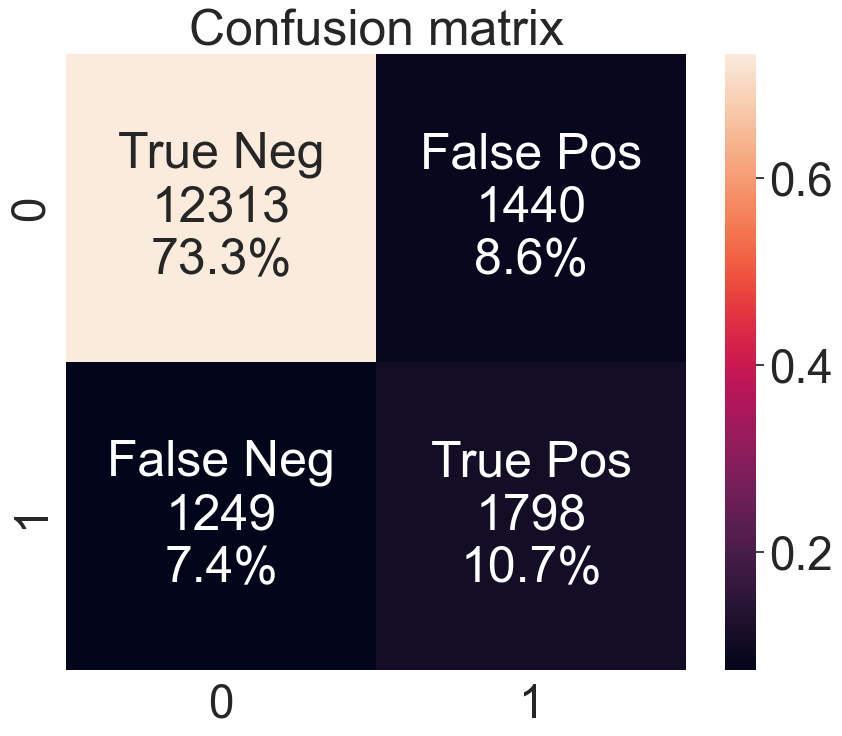

In [244]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.rcParams["figure.figsize"] = (10,8)
ax = sns.heatmap(cm/np.sum(cm), annot=labels,
            fmt='')
sns.set(font_scale=3)
ax.set_title('Confusion matrix')
plt.show()